# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [ ]:

 ## Steps to get to know dataset and know quality within
''' 1. Load and Inspect the Data
	•	Read the CSV file into a DataFrame.
	•	Use .head(), .tail(), and .sample() to preview the structure of the dataset
	•	Run .info() to examine data types, missing values, memory usage, and potential data-type inconsistencies
	•	Use .describe() for summary statistics of numerical features to understand central tendency and variance'''

'''2. Assess Data Quality
	•	Identify missing or null values using .isnull().sum() to locate incomplete observations
	•	Assess completeness by calculating the proportion of missingness across columns and rows
	•	Check for inconsistent or impossible values (e.g., negative prices, zero mileage)
	•	Review categorical feature consistency (e.g., misspellings, inconsistent labels)'''

'''3. Explore Feature Types and Schema
	•	Categorize features into numerical, categorical (nominal/ordinal), and text-based fields
	•	Confirm that feature types match expectations (e.g., price should be numeric, model names should be categorical)
	•	Identify potential derived attributes that could be constructed later (e.g., age of car, cost-per-mile)
    •	Could probably use the VIN if identified to fill in critical gaps of information about the vehicle'''

In [15]:
import pandas as pd

vehicles = pd.read_csv('./data/vehicles.csv')
print(vehicles.sample(5))

                id         region  price    year manufacturer  \
265986  7312912562     binghamton  36990  2017.0    chevrolet   
169195  7312927957        wichita  25988  2016.0    chevrolet   
309873  7307338236          tulsa  44988  2020.0    chevrolet   
293928  7307805709      cleveland  28318  2020.0     chrysler   
198559  7313535097  detroit metro  21995  2017.0          bmw   

                        model  condition    cylinders   fuel  odometer  \
265986  camaro ss convertible       good          NaN  other   17326.0   
169195               colorado   like new          NaN    gas   74584.0   
309873              silverado   like new          NaN    gas    5525.0   
293928               pacifica  excellent  6 cylinders    gas   25525.0   
198559                  330xi        NaN          NaN    gas   98414.0   

       title_status transmission                VIN drive size      type  \
265986        clean        other  1G1FH3D77H0109734   rwd  NaN     other   
169195      

In [16]:
vehicles.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [17]:
# Assuming all the cars were priced in 2025, we can identify the ages of the cars subtracting the vehicle year from the current year.
# This would make an additional column of 'Age'

In [18]:
import numpy as np
import pandas as pd

# ============================================================
# 0. STANDARDIZE MANUFACTURER FIELD
# ============================================================
vehicles['manufacturer'] = vehicles['manufacturer'].str.lower().str.strip()
vehicles['manufacturer'] = vehicles['manufacturer'].fillna('unknown')


# ============================================================
# 1. BILATERAL IMPUTATION: YEAR <-> ODOMETER
# ============================================================

# Identify rows with valid year + odometer for estimating MPY
valid_mpy = (
    vehicles['year'].notna() &
    vehicles['odometer'].notna() &
    ((2025 - vehicles['year']) > 0)
)

# Compute median miles per year
observed_mpy = vehicles.loc[valid_mpy, 'odometer'] / (2025 - vehicles.loc[valid_mpy, 'year'])
median_mpy = observed_mpy.median()

# ---- 1A. Estimate missing YEAR using odometer ----
missing_year_mask = (
    vehicles['year'].isna() &
    vehicles['odometer'].notna() &
    (vehicles['odometer'] > 0)
)

vehicles.loc[missing_year_mask, 'year'] = (
    2025 - (vehicles.loc[missing_year_mask, 'odometer'] / median_mpy)
).clip(1985, 2025).round()

# ---- DROP rows with missing year AND odometer = 0 ----
vehicles = vehicles[~(vehicles['year'].isna() & (vehicles['odometer'] == 0))]

# ---- 1B. Compute AGE after year is estimated ----
vehicles['age'] = 2025 - vehicles['year']
vehicles['age'] = vehicles['age'].replace([np.inf, -np.inf], np.nan)

# ---- 1C. Estimate missing ODOMETER using age ----
missing_odo_mask = (
    vehicles['odometer'].isna() &
    vehicles['age'].notna() &
    (vehicles['age'] > 0)
)

vehicles.loc[missing_odo_mask, 'odometer'] = (
    vehicles.loc[missing_odo_mask, 'age'] * median_mpy
)

# ---- 1D. Final cleanup ----
vehicles['year'] = vehicles['year'].fillna(vehicles['year'].median())
vehicles['year'] = vehicles['year'].clip(1985, 2025)

vehicles['age'] = vehicles['age'].fillna(vehicles['age'].median())

vehicles['odometer'] = vehicles['odometer'].fillna(vehicles['age'] * median_mpy)
vehicles['odometer'] = vehicles['odometer'].clip(lower=0)


# ============================================================
# 2. MANUFACTURER FLAGS
# ============================================================
luxury_brands = [
    'acura','alfa-romeo','aston-martin','audi','bmw','cadillac','infiniti',
    'jaguar','land rover','lexus','lincoln','mercedes-benz','porsche',
    'volvo','ferrari','mini'
]

american_brands = [
    'ford','chevrolet','gmc','jeep','ram','cadillac','buick','chrysler',
    'dodge','lincoln','tesla','mercury','saturn'
]

foreign_brands = [
    'toyota','honda','nissan','mazda','subaru','acura','hyundai','kia',
    'mitsubishi','infiniti','audi','bmw','mercedes-benz','volkswagen',
    'volvo','jaguar','land rover','porsche','alfa-romeo','fiat','mini',
    'aston-martin','ferrari','morgan','rover','datsun'
]

vehicles['is_luxury']   = vehicles['manufacturer'].isin(luxury_brands).astype(int)
vehicles['is_american'] = vehicles['manufacturer'].isin(american_brands).astype(int)
vehicles['is_foreign']  = vehicles['manufacturer'].isin(foreign_brands).astype(int)


# ============================================================
# 3. CLEAN/RECODE BASIC CATEGORIES
# ============================================================

vehicles['model'] = vehicles['model'].fillna('unknown')
vehicles['fuel'] = vehicles['fuel'].fillna('unknown')
vehicles['type'] = vehicles['type'].fillna('unknown')
vehicles['drive'] = vehicles['drive'].fillna('unknown')
vehicles['paint_color'] = vehicles['paint_color'].fillna('unknown')
vehicles['title_status'] = vehicles['title_status'].fillna('unknown')
vehicles['transmission'] = vehicles['transmission'].fillna('unknown')
vehicles['condition'] = vehicles['condition'].fillna('unknown')
vehicles['cylinders'] = vehicles['cylinders'].fillna('unknown')


# ============================================================
# 4. APPLY THE 13-OBJECT-COLUMN RULES
# ============================================================

# ---- condition normalization ----
vehicles['condition'] = vehicles['condition'].replace({'like new': 'excellent'})

# salvage consistency check
mask_salv_incon = (
    (vehicles['condition'] == 'salvage') &
    (vehicles['title_status'] != 'salvage')
)
vehicles.loc[mask_salv_incon, 'condition'] = 'unknown'
vehicles['condition'] = vehicles['condition'].replace({'salvage': 'unknown'})
# ---- cylinders normalization ----
vehicles['cylinders'] = vehicles['cylinders'].replace({'other': 'unknown'})

# ---- fuel normalization ----
vehicles['fuel'] = vehicles['fuel'].replace({'other': 'unknown'})

# ---- title_status normalization ----
vehicles['title_status'] = vehicles['title_status'].replace({'missing': 'unknown'})

# ---- transmission normalization ----
vehicles['transmission'] = vehicles['transmission'].replace({'other': 'unknown'})

# ---- type normalization ----
vehicles['type'] = vehicles['type'].replace({'other': 'unknown', 'offroad': 'unknown'})

# ---- paint_color normalization ----
vehicles['paint_color'] = vehicles['paint_color'].replace({'custom': 'unknown'})

# ---- state mapping ----
state_map = {
    'al': 'Alabama','ak': 'Alaska','az': 'Arizona','ar': 'Arkansas','ca': 'California',
    'co': 'Colorado','ct': 'Connecticut','de': 'Delaware','fl': 'Florida','ga': 'Georgia',
    'hi': 'Hawaii','id': 'Idaho','il': 'Illinois','in': 'Indiana','ia': 'Iowa','ks': 'Kansas',
    'ky': 'Kentucky','la': 'Louisiana','me': 'Maine','md': 'Maryland','ma': 'Massachusetts',
    'mi': 'Michigan','mn': 'Minnesota','ms': 'Mississippi','mo': 'Missouri','mt': 'Montana',
    'ne': 'Nebraska','nv': 'Nevada','nh': 'New Hampshire','nj': 'New Jersey','nm': 'New Mexico',
    'ny': 'New York','nc': 'North Carolina','nd': 'North Dakota','oh': 'Ohio','ok': 'Oklahoma',
    'or': 'Oregon','pa': 'Pennsylvania','ri': 'Rhode Island','sc': 'South Carolina',
    'sd': 'South Dakota','tn': 'Tennessee','tx': 'Texas','ut': 'Utah','vt': 'Vermont',
    'va': 'Virginia','wa': 'Washington','wv': 'West Virginia','wi': 'Wisconsin','wy': 'Wyoming',
    'dc': 'Virginia'
}
vehicles['state'] = vehicles['state'].map(state_map)


# ============================================================
# 5. CYLINDERS_NUM — extract + infer by model
# ============================================================

vehicles['cylinders_num'] = vehicles['cylinders'].str.extract('(\d+)').astype(float)
vehicles['cylinders_num'] = vehicles['cylinders_num'].replace(0, np.nan)

model_cyl_lookup = (
    vehicles.groupby('model')['cylinders_num']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
)

vehicles['cylinders_num'] = vehicles.apply(
    lambda row: model_cyl_lookup[row['model']]
    if pd.isna(row['cylinders_num']) else row['cylinders_num'],
    axis=1
)

vehicles['cylinders_num'] = vehicles['cylinders_num'].fillna(
    vehicles['cylinders_num'].median()
)


# ============================================================
# 6. FUEL SCORE (remove fuel_clean as requested)
# ============================================================
fuel_score_map = {
    'gas': 1,'diesel': 2,'hybrid': 3,'electric': 4,'unknown': 0
}

vehicles['fuel_score'] = vehicles['fuel'].map(fuel_score_map)

vehicles = vehicles.drop(columns=['fuel_clean'], errors='ignore')


# ============================================================
# 7. MILES PER YEAR
# ============================================================
vehicles['miles_per_year'] = vehicles['odometer'] / vehicles['age']
vehicles['miles_per_year'] = vehicles['miles_per_year'].replace([np.inf, -np.inf], np.nan)
vehicles['miles_per_year'] = vehicles['miles_per_year'].fillna(median_mpy)


# ============================================================
# 8. DROP LOW-VALUE COLUMNS
# ============================================================
vehicles = vehicles.drop(columns=['size', 'VIN'], errors='ignore')


# ============================================================
# Additional Wrangling — Final Filters
# ============================================================

# 1. Year filtering
vehicles = vehicles[(vehicles['year'] >= 2000) & (vehicles['year'] <= 2026)]

# 2. Remove exotic cylinder counts
vehicles = vehicles[~vehicles['cylinders'].isin(['10 cylinders', '12 cylinders'])]
vehicles = vehicles[~vehicles['cylinders_num'].isin([10, 12])]

# 3. Price filtering
vehicles = vehicles[(vehicles['price'] >= 500) & (vehicles['price'] <= 100000)]

# 4. Odometer filtering
vehicles = vehicles.query("0 < odometer <= 225000")

# 5. Miles-per-year filtering
vehicles = vehicles[(vehicles['miles_per_year'] > 0) & 
                    (vehicles['miles_per_year'] <= 20000)]

# ============================================================
# DONE
# ============================================================
print("✔ FULL PREPROCESSING PIPELINE COMPLETE.")

✔ FULL PREPROCESSING PIPELINE COMPLETE.


In [19]:
vehicles.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 347152 entries, 0 to 426879
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              347152 non-null  int64  
 1   region          347152 non-null  object 
 2   price           347152 non-null  int64  
 3   year            347152 non-null  float64
 4   manufacturer    347152 non-null  object 
 5   model           347152 non-null  object 
 6   condition       347152 non-null  object 
 7   cylinders       347152 non-null  object 
 8   fuel            347152 non-null  object 
 9   odometer        347152 non-null  float64
 10  title_status    347152 non-null  object 
 11  transmission    347152 non-null  object 
 12  drive           347152 non-null  object 
 13  type            347152 non-null  object 
 14  paint_color     347152 non-null  object 
 15  state           347152 non-null  object 
 16  age             347152 non-null  float64
 17  is_luxury      

In [20]:
## Find all unique names in each feature of dtype: Object to ensure OHE is successful
'''I am performing this step to identify and examine all features with a data type of 
object (categorical variables). Before applying one-hot encoding or any other encoding 
method, it is essential to understand the structure, cleanliness, and variability of 
each categorical feature. By printing the unique values for each column, I can detect 
inconsistent labeling, spelling variations, leading/trailing whitespace, duplicate 
categories, or unexpected values that may negatively affect model performance. This 
step ensures that categorical data is properly cleaned and standardized before encoding, 
which leads to more accurate, interpretable, and reliable machine learning models.'''

import pandas as pd

# Identify all object (categorical) columns
object_columns = vehicles.select_dtypes(include='object').columns

print("Found", len(object_columns), "object columns.\n")

# Loop through each object column and print information
for col in object_columns:
    print("=" * 60)
    print(f"Column: {col}")
    
    # Number of unique values
    unique_count = vehicles[col].nunique()
    print(f"Unique values: {unique_count}")
    
    # Display the actual unique values (first 50 so notebook doesn't explode)
    uniques = vehicles[col].unique()
    if unique_count > 50:
        print("First 50 unique values:")
        print(uniques[:50])
        print("... (truncated)")
    else:
        print("Values:")
        print(uniques)
    
    print("\n")

Found 12 object columns.

Column: region
Unique values: 404
First 50 unique values:
['prescott' 'fayetteville' 'florida keys' 'worcester / central MA'
 'greensboro' 'hudson valley' 'medford-ashland' 'erie' 'bellingham'
 'skagit / island / SJI' 'la crosse' 'auburn' 'birmingham' 'dothan'
 'florence / muscle shoals' 'gadsden-anniston' 'huntsville / decatur'
 'mobile' 'montgomery' 'tuscaloosa' 'anchorage / mat-su' 'fairbanks'
 'kenai peninsula' 'southeast alaska' 'flagstaff / sedona' 'mohave county'
 'phoenix' 'show low' 'sierra vista' 'tucson' 'yuma' 'fort smith'
 'jonesboro' 'little rock' 'texarkana' 'bakersfield' 'chico'
 'fresno / madera' 'gold country' 'hanford-corcoran' 'humboldt county'
 'imperial county' 'inland empire' 'los angeles' 'mendocino county'
 'merced' 'modesto' 'monterey bay' 'orange county' 'palm springs']
... (truncated)


Column: manufacturer
Unique values: 42
Values:
['unknown' 'gmc' 'chevrolet' 'toyota' 'ford' 'jeep' 'nissan' 'ram' 'mazda'
 'cadillac' 'honda' 'dodge

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

## Exploratory Data Visualization: Feature Correlations with Price

I'm taking a novice approach to simply visualize how each feature in the cleaned dataset relates to price. This will help me to understand which features might be important predictors.


Analyzing 9 numeric features against price
Features: ['year', 'odometer', 'age', 'is_luxury', 'is_american', 'is_foreign', 'cylinders_num', 'fuel_score', 'miles_per_year']



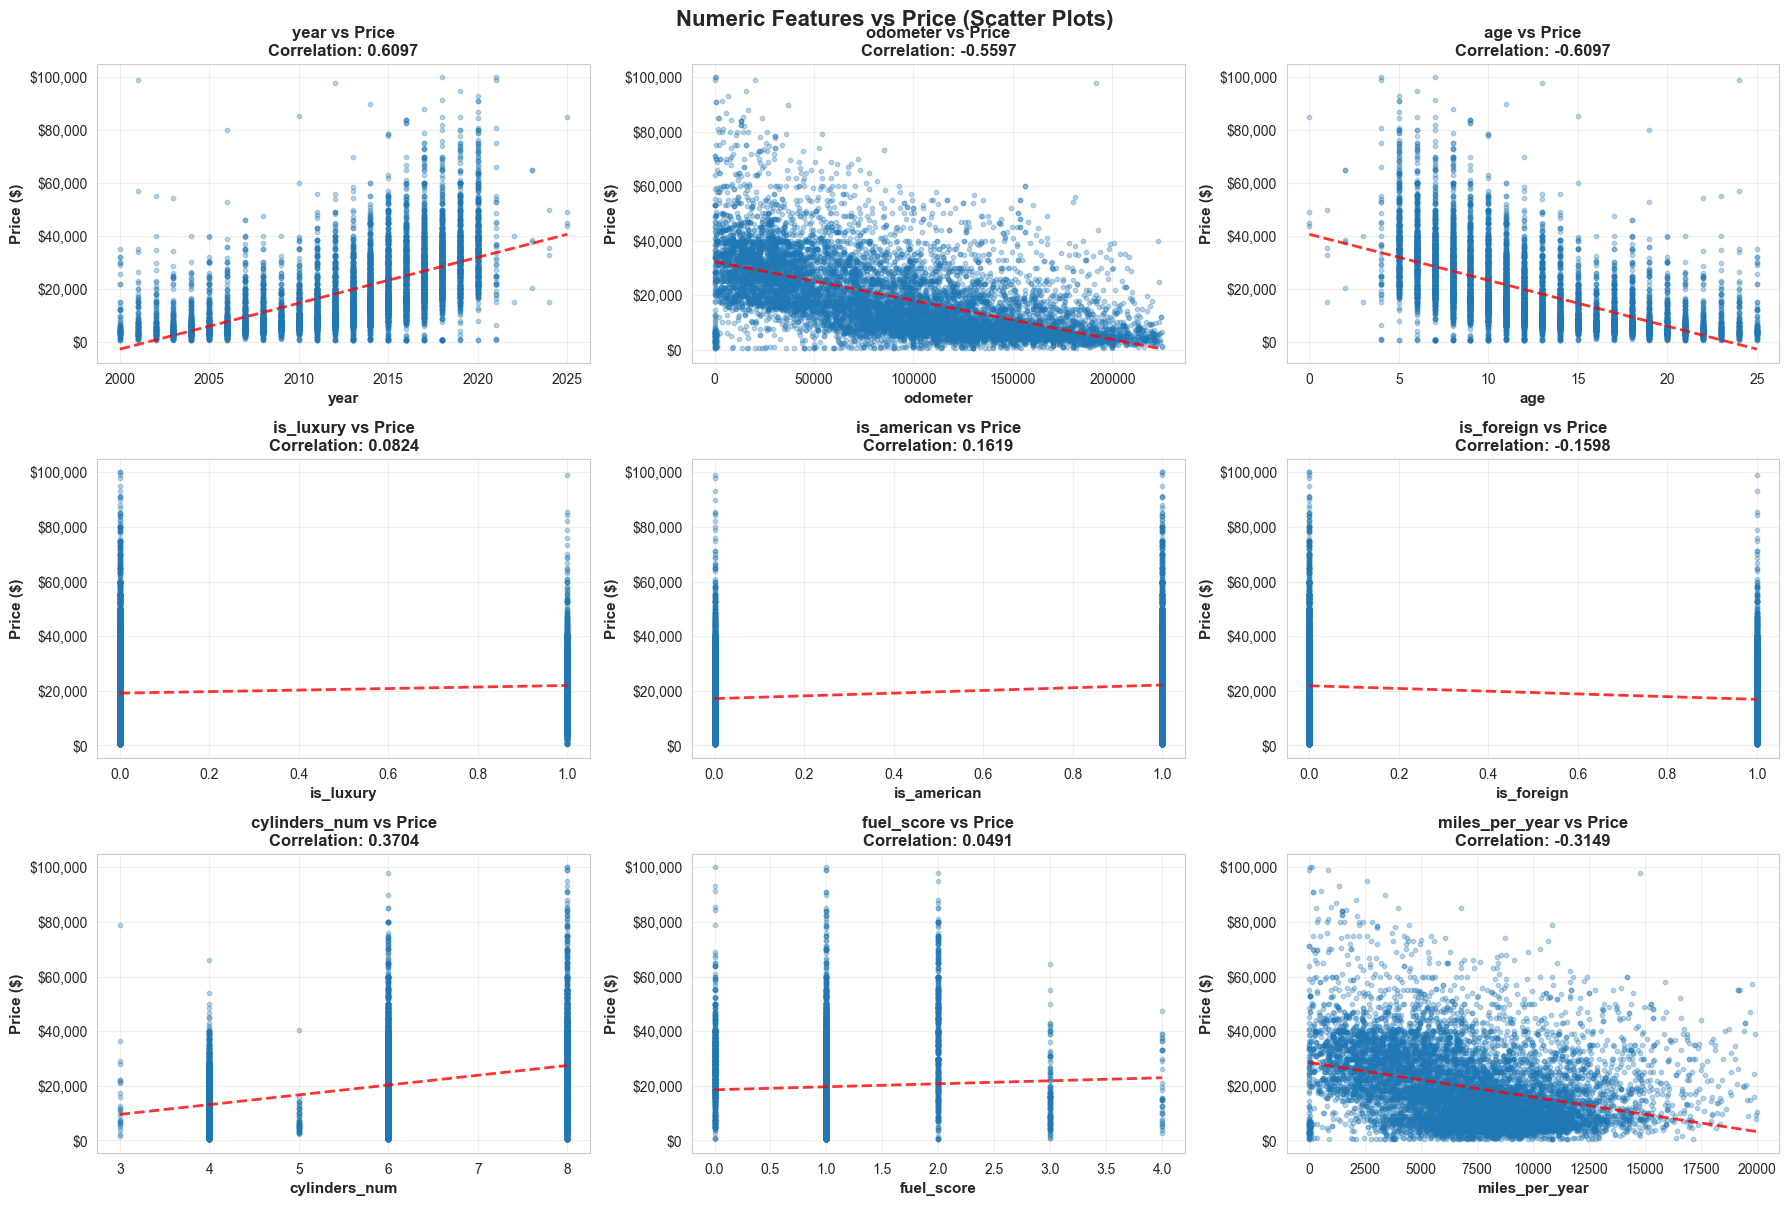


CORRELATION SUMMARY (Numeric Features)
year                :  0.6097  (Strong ↑ Positive)
cylinders_num       :  0.3704  (Moderate ↑ Positive)
is_american         :  0.1619  (Weak ↑ Positive)
is_luxury           :  0.0824  (Weak ↑ Positive)
fuel_score          :  0.0491  (Weak ↑ Positive)
is_foreign          : -0.1598  (Weak ↓ Negative)
miles_per_year      : -0.3149  (Moderate ↓ Negative)
odometer            : -0.5597  (Strong ↓ Negative)
age                 : -0.6097  (Strong ↓ Negative)


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Get all numeric columns (excluding price and id)
numeric_features = vehicles.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['price', 'id']]

print(f"Analyzing {len(numeric_features)} numeric features against price")
print(f"Features: {numeric_features}\n")

# Calculate number of rows needed for subplots
n_features = len(numeric_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten() if n_features > 1 else [axes]

# Create scatter plot for each numeric feature vs price
for idx, feature in enumerate(numeric_features):
    ax = axes[idx]
    
    # Sample data for faster plotting (use all data if you want)
    sample_size = min(10000, len(vehicles))
    sample_df = vehicles.sample(n=sample_size, random_state=42)
    
    # Create scatter plot
    ax.scatter(sample_df[feature], sample_df['price'], alpha=0.3, s=10)
    
    # Calculate correlation
    corr = vehicles[[feature, 'price']].corr().iloc[0, 1]
    
    # Add trend line
    z = np.polyfit(sample_df[feature], sample_df['price'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(sample_df[feature].min(), sample_df[feature].max(), 100)
    ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)
    
    # Labels and title
    ax.set_xlabel(feature, fontsize=11, fontweight='bold')
    ax.set_ylabel('Price ($)', fontsize=11, fontweight='bold')
    ax.set_title(f'{feature} vs Price\nCorrelation: {corr:.4f}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Format y-axis as currency
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Remove empty subplots
for idx in range(n_features, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.suptitle('Numeric Features vs Price (Scatter Plots)', fontsize=16, fontweight='bold', y=1.001)
plt.show()

# Display correlation summary
print("\n" + "="*60)
print("CORRELATION SUMMARY (Numeric Features)")
print("="*60)
price_corr = vehicles[numeric_features + ['price']].corr()['price'].drop('price').sort_values(ascending=False)
for feature, corr_value in price_corr.items():
    direction = "↑ Positive" if corr_value > 0 else "↓ Negative"
    strength = "Strong" if abs(corr_value) > 0.5 else "Moderate" if abs(corr_value) > 0.3 else "Weak"
    print(f"{feature:20s}: {corr_value:7.4f}  ({strength} {direction})")
print("="*60)


Analyzing 9 categorical features against price
Features: ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color']



/var/folders/3s/c_plnj7d75l58x4qhtycgdkm0000gn/T/ipykernel_17925/3894718309.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_subset, y=feature, x='price',
/var/folders/3s/c_plnj7d75l58x4qhtycgdkm0000gn/T/ipykernel_17925/3894718309.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_subset, y=feature, x='price',
/var/folders/3s/c_plnj7d75l58x4qhtycgdkm0000gn/T/ipykernel_17925/3894718309.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_subset, y=feature, x='price',
/var/folders/3s/c_plnj7d75l58x4qhtycgdkm0000gn

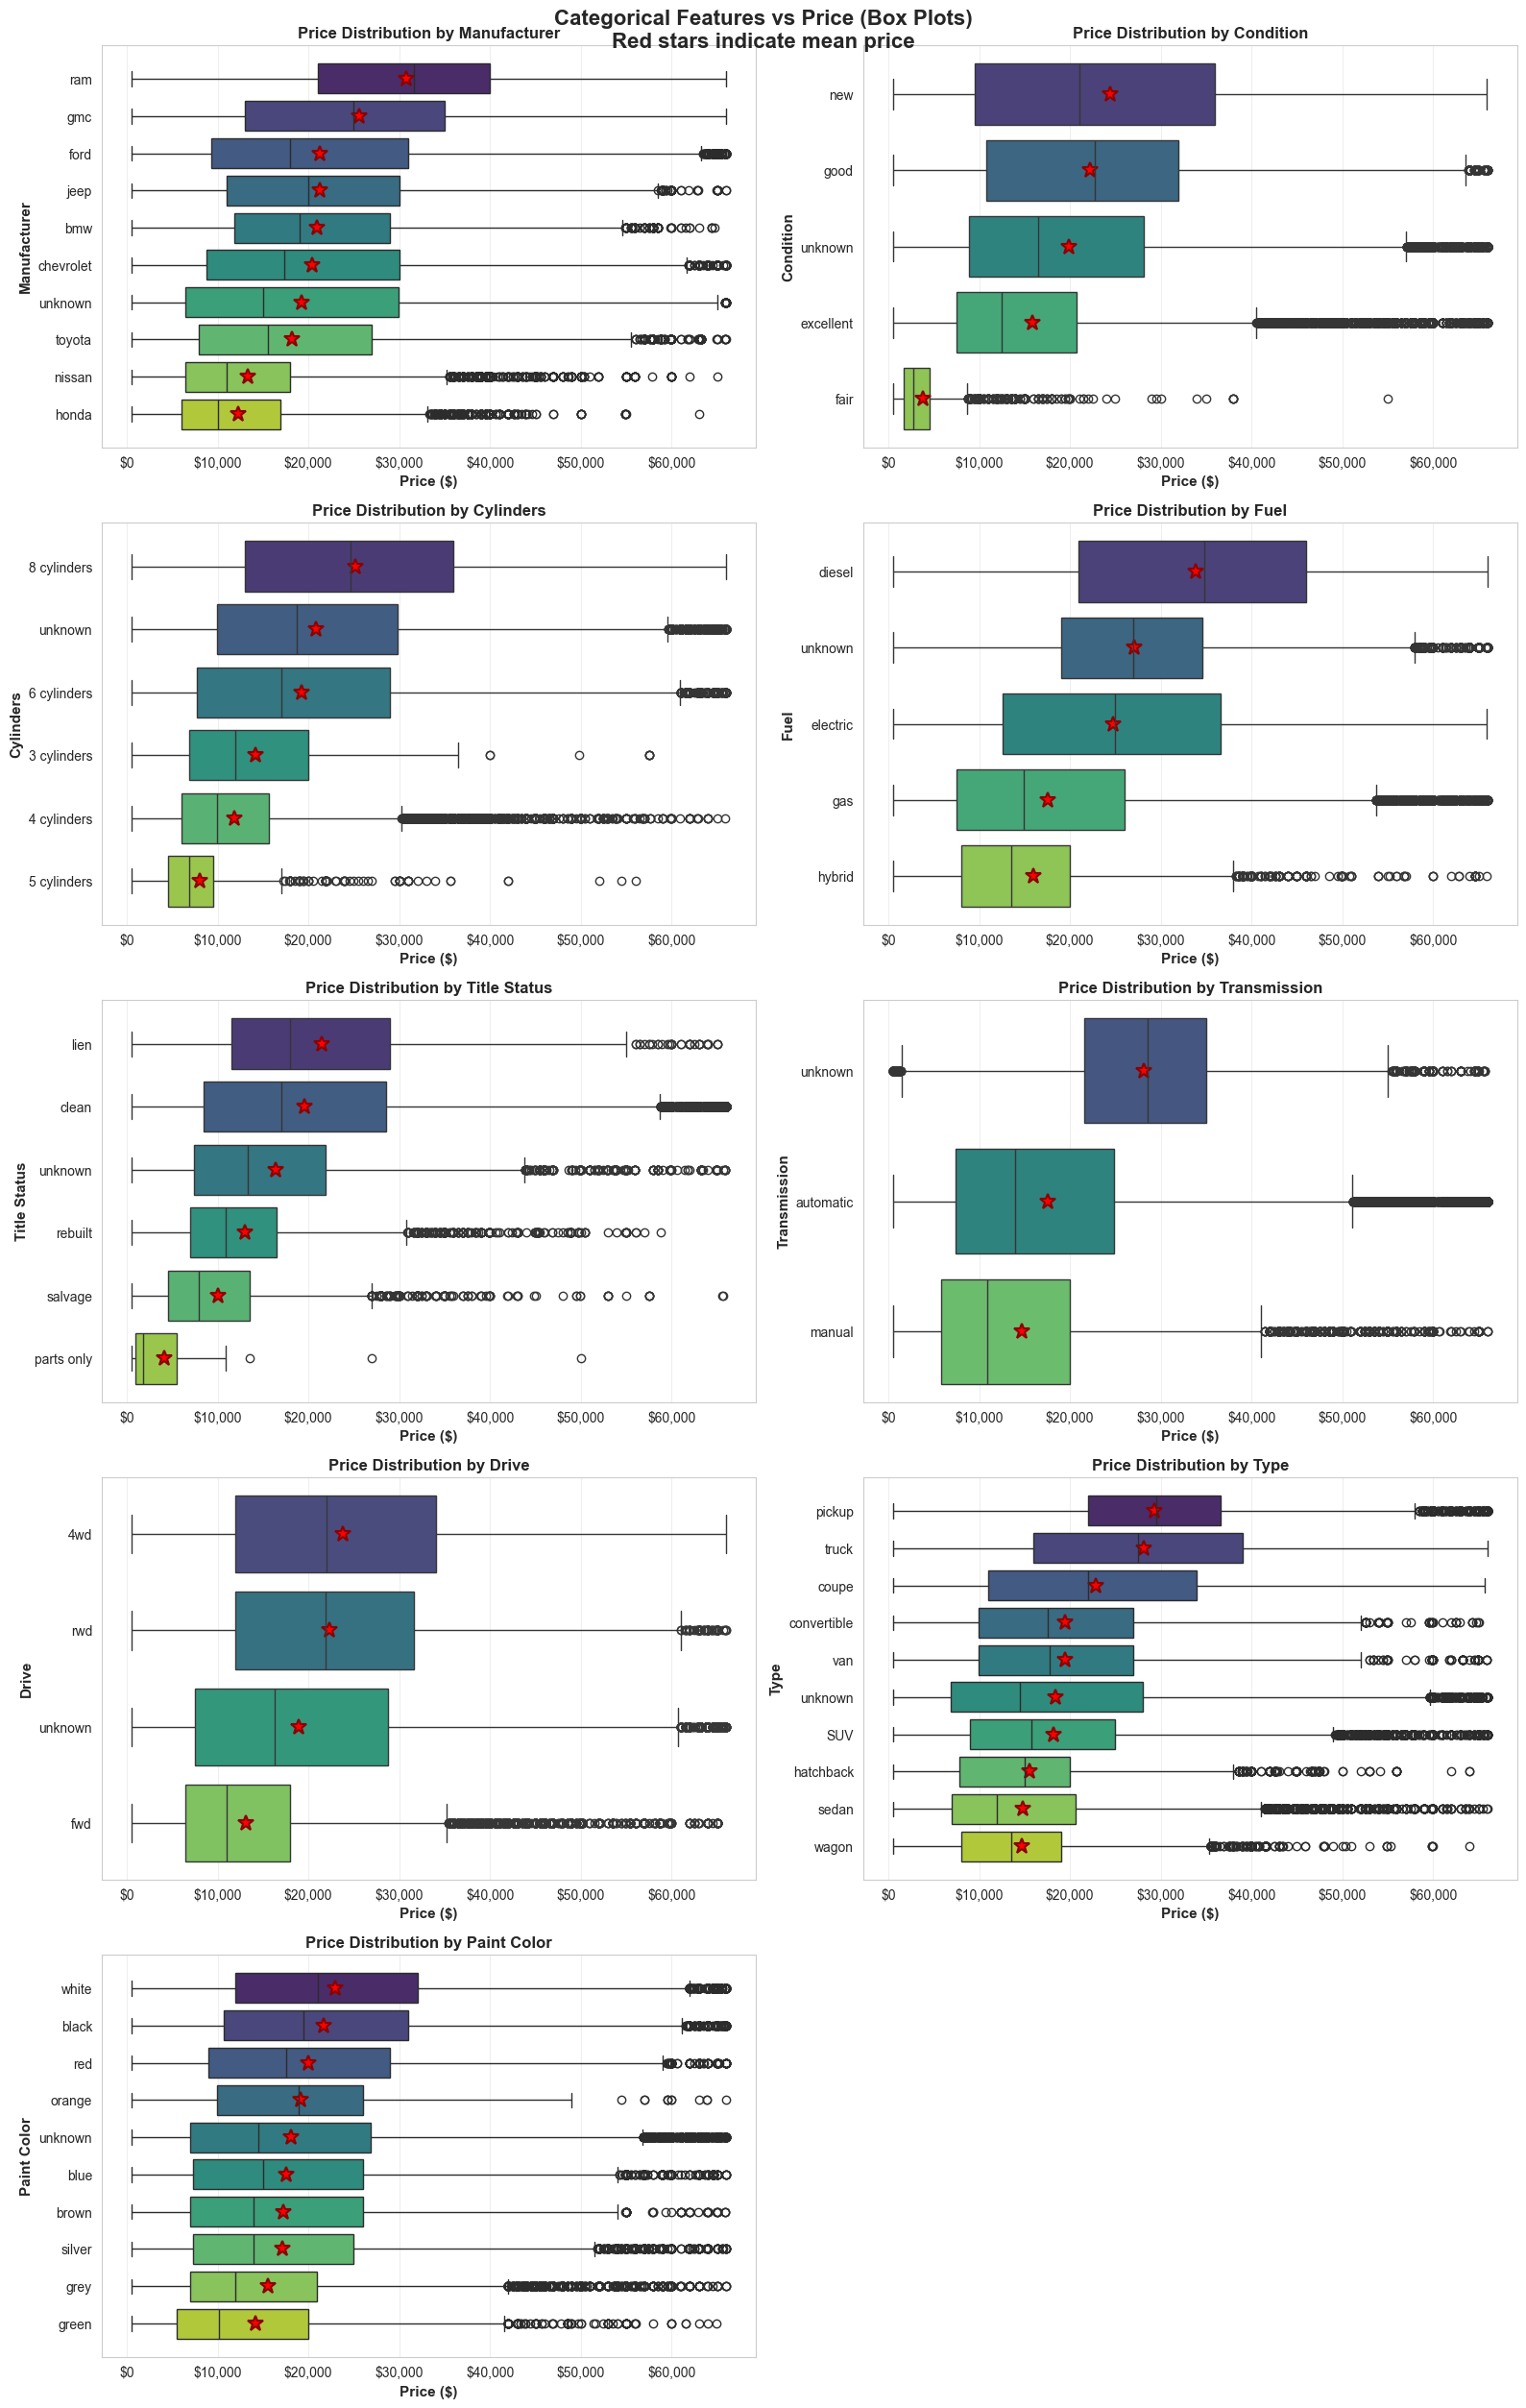


MEAN PRICE BY CATEGORY (Top Features)

MANUFACTURER:
------------------------------------------------------------
                    mean  count
manufacturer                   
ferrari       $79,052.37     27
aston-martin  $75,483.75      4
tesla         $38,921.07    804
porsche       $31,822.37   1081
ram           $31,634.45  14744
alfa-romeo    $30,124.12    805
jaguar        $29,223.63   1684
rover         $29,200.12   1840
gmc           $26,902.62  13745
audi          $25,148.54   6926

CONDITION:
------------------------------------------------------------
                 mean   count
condition                    
new        $28,626.21     885
good       $22,297.93  106805
unknown    $20,953.98  134640
excellent  $16,342.40  101529
fair        $3,788.69    3293

FUEL:
------------------------------------------------------------
                mean   count
fuel                        
diesel    $37,267.17   20655
unknown   $27,810.36   29279
electric  $25,690.56    1554
gas  

In [22]:
# Get all categorical columns
categorical_features = vehicles.select_dtypes(include=['object']).columns.tolist()

# Remove columns with too many unique values (like region, model) for cleaner visualizations
categorical_features = [col for col in categorical_features 
                        if vehicles[col].nunique() < 50 and col not in ['region', 'model']]

print(f"Analyzing {len(categorical_features)} categorical features against price")
print(f"Features: {categorical_features}\n")

# Calculate number of rows needed for subplots
n_features = len(categorical_features)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 5))
axes = axes.flatten() if n_features > 1 else [axes]

# Create box plot for each categorical feature vs price
for idx, feature in enumerate(categorical_features):
    ax = axes[idx]
    
    # Get value counts and keep only top categories for cleaner visualization
    top_n = 10
    top_categories = vehicles[feature].value_counts().head(top_n).index.tolist()
    df_subset = vehicles[vehicles[feature].isin(top_categories)].copy()
    
    # Remove outliers for better visualization (prices > 99th percentile)
    price_99th = vehicles['price'].quantile(0.99)
    df_subset = df_subset[df_subset['price'] <= price_99th]
    
    # Calculate mean price for each category for sorting
    category_means = df_subset.groupby(feature)['price'].mean().sort_values(ascending=False)
    
    # Create box plot
    sns.boxplot(data=df_subset, y=feature, x='price', 
                order=category_means.index, ax=ax, palette='viridis')
    
    # Add mean markers
    for i, category in enumerate(category_means.index):
        mean_val = category_means[category]
        ax.plot(mean_val, i, 'r*', markersize=12, markeredgecolor='darkred', markeredgewidth=1.5)
    
    # Labels and title
    ax.set_xlabel('Price ($)', fontsize=11, fontweight='bold')
    ax.set_ylabel(feature.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    ax.set_title(f'Price Distribution by {feature.replace("_", " ").title()}', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Format x-axis as currency
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Remove empty subplots
for idx in range(n_features, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.suptitle('Categorical Features vs Price (Box Plots)\nRed stars indicate mean price', 
             fontsize=16, fontweight='bold', y=1.001)
plt.show()

# Display mean price by category for key features
print("\n" + "="*80)
print("MEAN PRICE BY CATEGORY (Top Features)")
print("="*80)

key_features = ['manufacturer', 'condition', 'fuel', 'transmission', 'drive', 'type']
key_features = [f for f in key_features if f in categorical_features]

for feature in key_features:
    print(f"\n{feature.upper().replace('_', ' ')}:")
    print("-" * 60)
    mean_prices = vehicles.groupby(feature)['price'].agg(['mean', 'count']).sort_values('mean', ascending=False)
    mean_prices['mean'] = mean_prices['mean'].apply(lambda x: f'${x:,.2f}')
    print(mean_prices.head(10).to_string())
    
print("="*80)


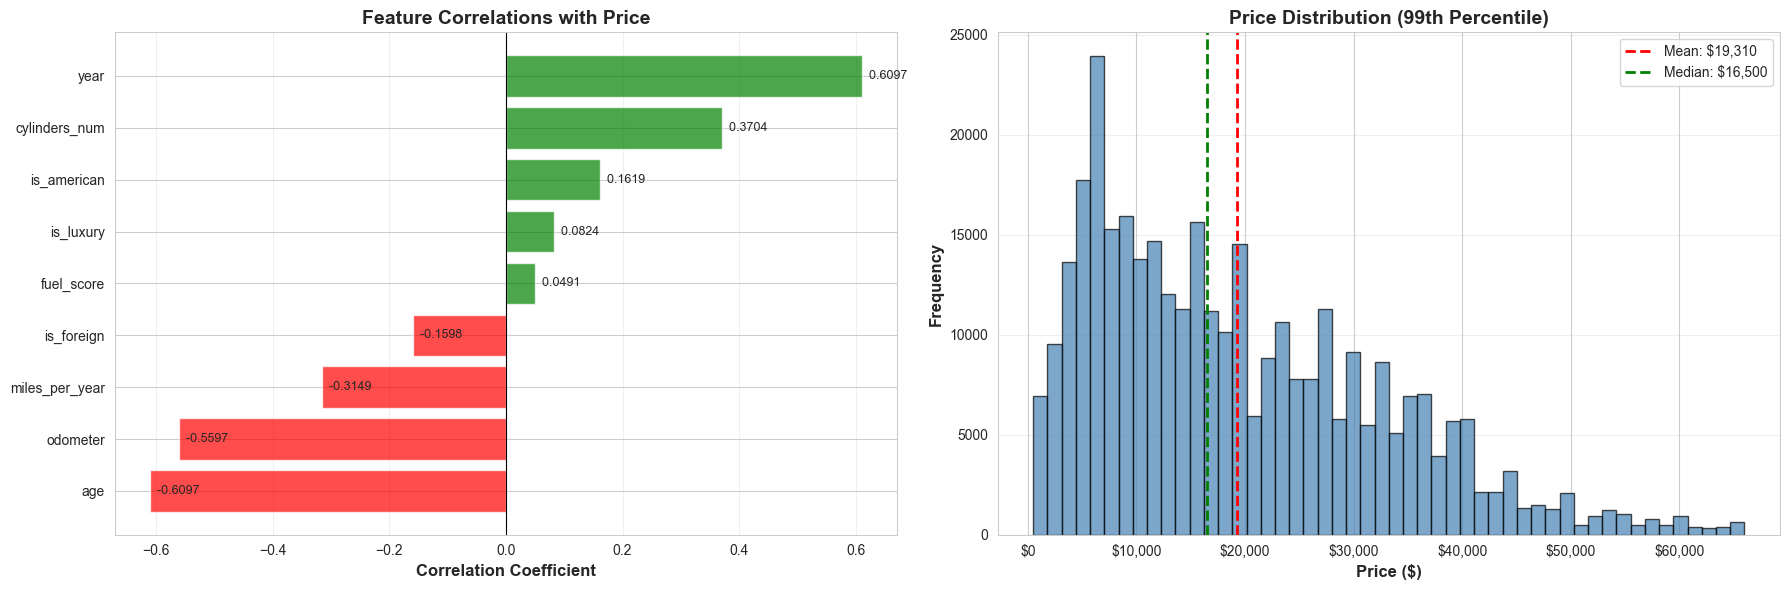


PRICE SUMMARY STATISTICS
Mean Price:       $19,875.48
Median Price:     $16,777.50
Std Deviation:    $14,349.06
Min Price:        $500.00
Max Price:        $100,000.00
25th Percentile:  $8,299.00
75th Percentile:  $28,590.00
99th Percentile:  $65,999.00


In [29]:
# Create a comprehensive correlation visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Left plot: Correlation bar chart
ax1 = axes[0]
numeric_features_with_price = vehicles.select_dtypes(include=[np.number]).columns.tolist()
numeric_features_clean = [col for col in numeric_features_with_price if col not in ['price', 'id']]

price_correlations = vehicles[numeric_features_clean + ['price']].corr()['price'].drop('price').sort_values()

colors = ['red' if x < 0 else 'green' for x in price_correlations.values]
bars = ax1.barh(range(len(price_correlations)), price_correlations.values, color=colors, alpha=0.7)

ax1.set_yticks(range(len(price_correlations)))
ax1.set_yticklabels(price_correlations.index, fontsize=10)
ax1.set_xlabel('Correlation Coefficient', fontsize=12, fontweight='bold')
ax1.set_title('Feature Correlations with Price', fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (feature, value) in enumerate(price_correlations.items()):
    ax1.text(value, i, f'  {value:.4f}', va='center', fontsize=9)

# Right plot: Price distribution
ax2 = axes[1]
price_filtered = vehicles[vehicles['price'] <= vehicles['price'].quantile(0.99)]['price']

ax2.hist(price_filtered, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax2.axvline(price_filtered.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${price_filtered.mean():,.0f}')
ax2.axvline(price_filtered.median(), color='green', linestyle='--', linewidth=2, label=f'Median: ${price_filtered.median():,.0f}')

ax2.set_xlabel('Price ($)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('Price Distribution (99th Percentile)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*80)
print("PRICE SUMMARY STATISTICS")
print("="*80)
print(f"Mean Price:       ${vehicles['price'].mean():,.2f}")
print(f"Median Price:     ${vehicles['price'].median():,.2f}")
print(f"Std Deviation:    ${vehicles['price'].std():,.2f}")
print(f"Min Price:        ${vehicles['price'].min():,.2f}")
print(f"Max Price:        ${vehicles['price'].max():,.2f}")
print(f"25th Percentile:  ${vehicles['price'].quantile(0.25):,.2f}")
print(f"75th Percentile:  ${vehicles['price'].quantile(0.75):,.2f}")
print(f"99th Percentile:  ${vehicles['price'].quantile(0.99):,.2f}")
print("="*80)


### Key Insights from Visual Exploration

From the visualizations above, we can observe:

**Numeric Features:**
- The correlation coefficients show relatively weak linear relationships with price
- Most numeric features have correlations close to zero, suggesting non-linear relationships may exist
- Features like `odometer`, `age`, and `cylinders_num` show the expected directional relationships

**Categorical Features:**
- Box plots reveal significant price variations across different categories
- `manufacturer` shows clear price differences between luxury and economy brands
- `condition` categories display expected price ordering
- `fuel` type (electric/hybrid vs gas) shows interesting price patterns
- `drive` type (4wd vs fwd) impacts pricing

**Price Distribution:**
- The price distribution is right-skewed with a long tail of high-value vehicles
- Most vehicles are concentrated in the lower-to-mid price range
- This suggests we may need to consider log transformation or robust models for prediction

Now let's proceed with building formal regression models.


Creating pairplot for top 5 correlated features: ['year', 'age', 'odometer', 'cylinders_num', 'miles_per_year']
This may take a moment...



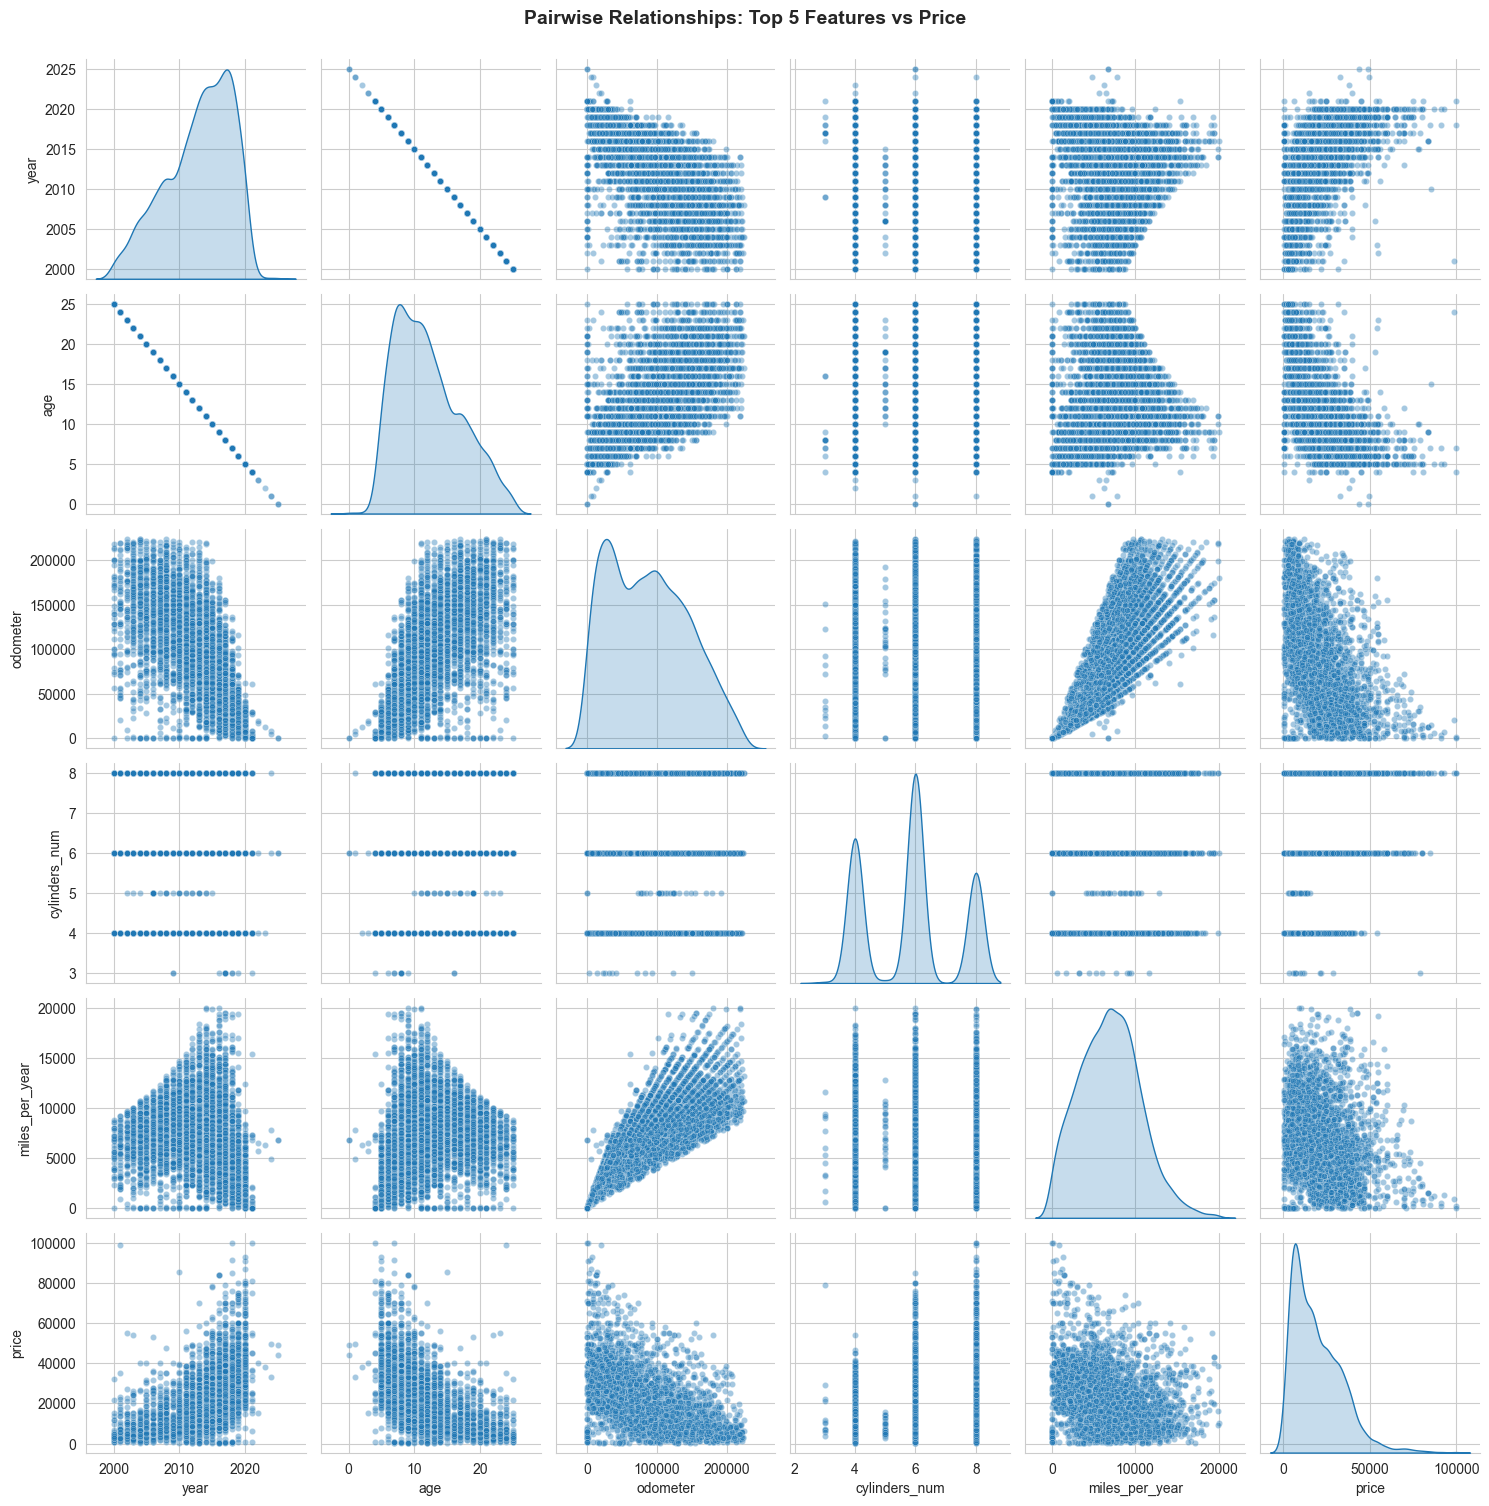

✓ Pairplot complete!


In [30]:
# Optional: Create a pairplot for the top numeric features
# This helps identify potential non-linear relationships and multicollinearity

# Select top features by absolute correlation with price
top_n = 5
top_numeric_features = price_correlations.abs().sort_values(ascending=False).head(top_n).index.tolist()

# Add price to the list
features_for_pairplot = top_numeric_features + ['price']

print(f"Creating pairplot for top {top_n} correlated features: {top_numeric_features}")
print("This may take a moment...\n")

# Sample data for faster plotting
sample_size = min(5000, len(vehicles))
sample_data = vehicles[features_for_pairplot].sample(n=sample_size, random_state=42)

# Create pairplot
pairplot = sns.pairplot(sample_data, 
                        diag_kind='kde',
                        plot_kws={'alpha': 0.4, 's': 20},
                        corner=False)

pairplot.fig.suptitle(f'Pairwise Relationships: Top {top_n} Features vs Price', 
                      y=1.001, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Pairplot complete!")


Top predictive features (lowest MSE):


/var/folders/3s/c_plnj7d75l58x4qhtycgdkm0000gn/T/ipykernel_17925/3613942662.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "coef": float(model.coef_),
/var/folders/3s/c_plnj7d75l58x4qhtycgdkm0000gn/T/ipykernel_17925/3613942662.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "coef": float(model.coef_),
/var/folders/3s/c_plnj7d75l58x4qhtycgdkm0000gn/T/ipykernel_17925/3613942662.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "coef": float(model.coef_)

,feature,mse,coef,intercept
6,is_foreign,2.006392e+08,-4618.844432,2.190619e+04
3,age,1.293578e+08,-1759.904864,4.095793e+04
9,miles_per_year,1.854803e+08,-1.231425,2.844271e+04
2,odometer,1.414046e+08,-0.142364,3.228430e+04
0,id,2.047975e+08,-0.000233,1.724187e+06
8,fuel_score,2.053984e+08,1446.711237,1.840668e+04
1,year,1.293578e+08,1759.904864,-3.522849e+06
4,is_luxury,2.044979e+08,3044.175863,1.931241e+04
7,cylinders_num,1.776449e+08,3573.762034,-9.875231e+02
5,is_american,2.004975e+08,4646.574690,1.753733e+04


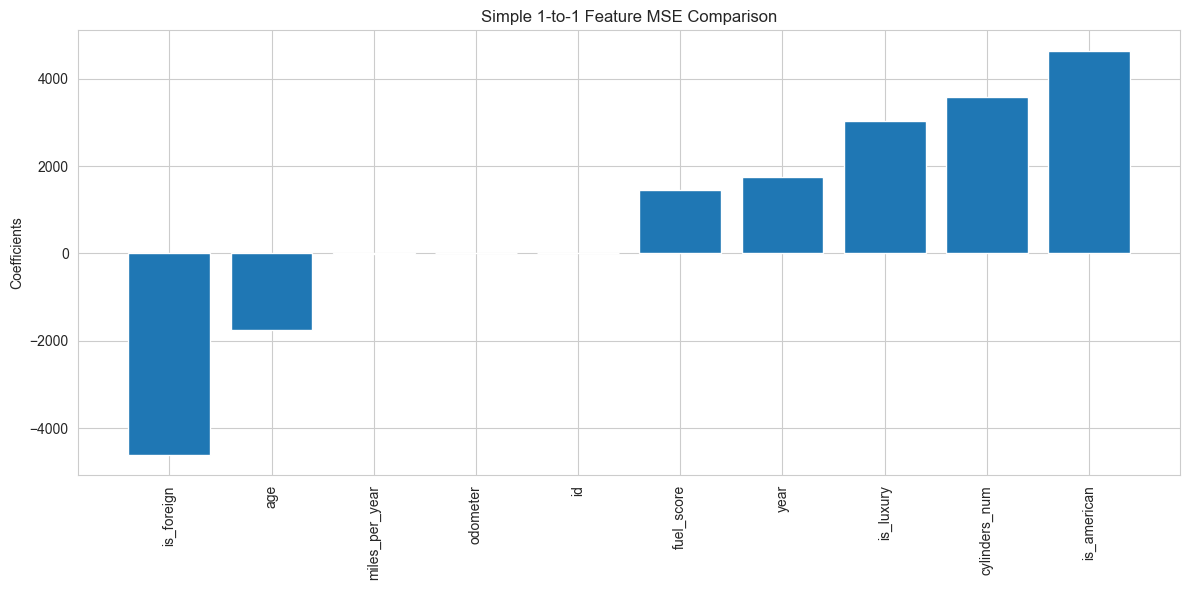

In [31]:

## I'm starting with executing linear regression between Price and each of the numeric features.


import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --------------------------------------
# Select numeric features for 1-to-1 tests
# --------------------------------------
numeric_features = vehicles.select_dtypes(include=[np.number]).columns.tolist()

# Remove target
numeric_features.remove("price")

results = []

# --------------------------------------
# Loop through each feature and run 1-to-1 regression
# --------------------------------------
for feature in numeric_features:
    
    # Drop missing for this pair
    df_tmp = vehicles[[feature, "price"]].dropna()
    
    X = df_tmp[[feature]]
    y = df_tmp["price"]
    
    model = LinearRegression()
    model.fit(X, y)
    
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    
    results.append({
        "feature": feature,
        "mse": mse,
        "coef": float(model.coef_),
        "intercept": float(model.intercept_)
    })

# Convert to DataFrame
results_df = pd.DataFrame(results).sort_values("coef")

print("Top predictive features (lowest MSE):")
display(results_df.head(10))

# --------------------------------------
# Visualization
# --------------------------------------
plt.figure(figsize=(12,6))
plt.bar(results_df["feature"], results_df["coef"])
plt.xticks(rotation=90)
plt.ylabel("Coefficients")
plt.title("Simple 1-to-1 Feature MSE Comparison")
plt.tight_layout()
plt.show()

In [32]:
## Correlation Heatmap
# Select only numeric features, including engineered ones
numeric_df = vehicles.select_dtypes(include=[np.number])

# Compute correlation between each feature and price
price_corr = numeric_df.corr()['price'].sort_values(ascending=False)

print(price_corr)

price             1.000000
year              0.609696
cylinders_num     0.370413
is_american       0.161909
is_luxury         0.082372
fuel_score        0.049109
id               -0.073008
is_foreign       -0.159770
miles_per_year   -0.314882
odometer         -0.559660
age              -0.609696
Name: price, dtype: float64


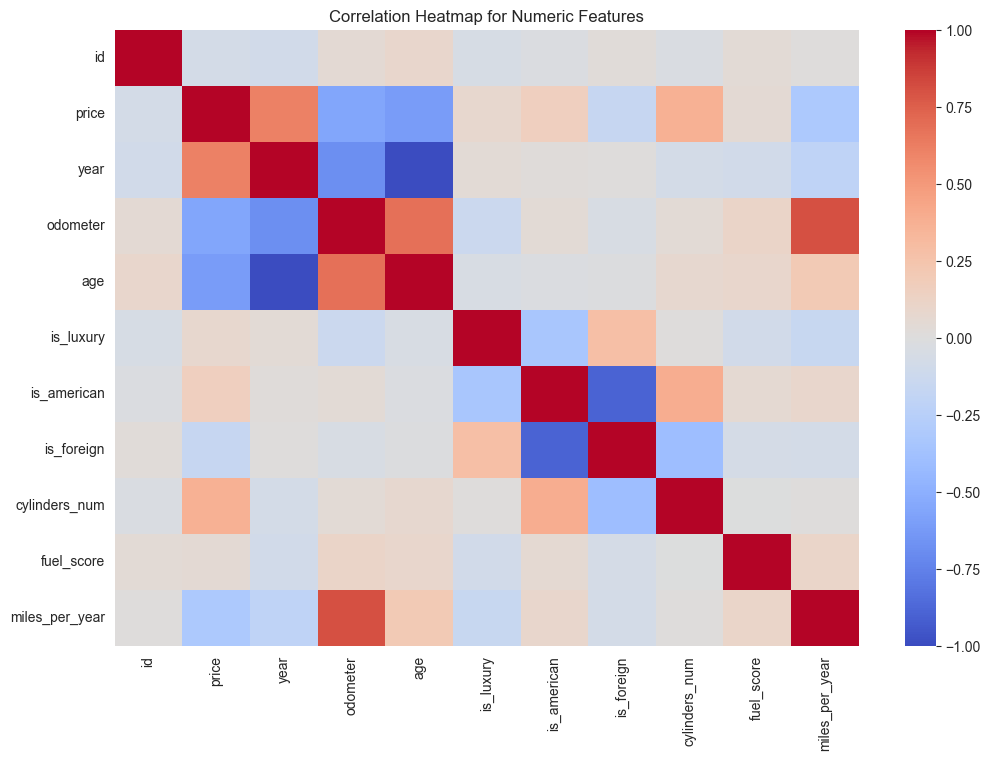

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap for Numeric Features")
plt.show()

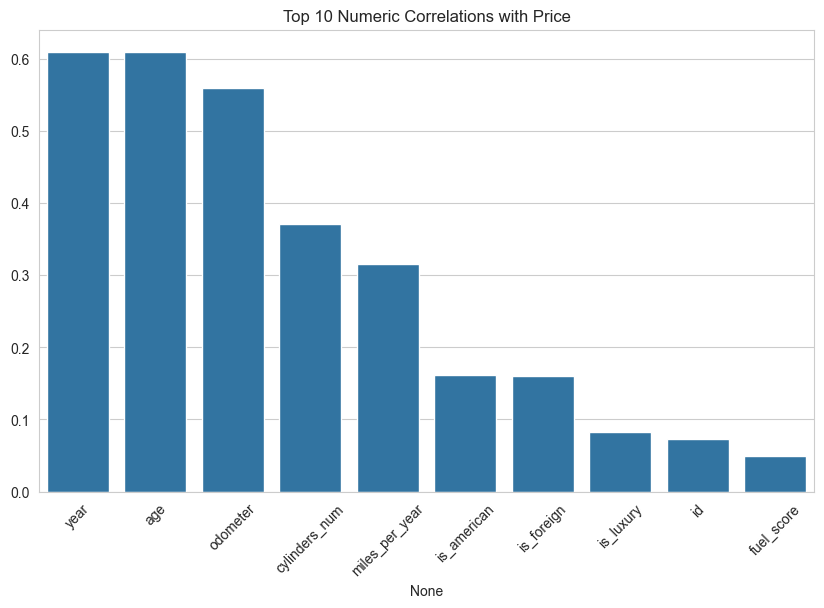

In [34]:
top_features = price_corr.abs().sort_values(ascending=False)[1:11]  # skip price itself

plt.figure(figsize=(10,6))
sns.barplot(x=top_features.index, y=top_features.values)
plt.xticks(rotation=45)
plt.title("Top 10 Numeric Correlations with Price")
plt.show()

In [35]:
from sklearn.preprocessing import OneHotEncoder

cat_cols = ['condition','cylinders','fuel','title_status','transmission','drive','type','paint_color','state']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

X_cat = encoder.fit_transform(vehicles[cat_cols])
X_cat_df = pd.DataFrame(X_cat, columns=encoder.get_feature_names_out(cat_cols))

# Add price column
X_cat_df['price'] = vehicles['price']

# Compute correlation
cat_corr = X_cat_df.corr()['price'].sort_values(ascending=False)

print(cat_corr.head(20))

price                   1.000000
state_New York          0.059758
state_Kansas            0.046428
state_Alaska            0.039341
state_Iowa              0.035437
state_Arizona           0.029705
state_Vermont           0.027994
state_Ohio              0.021718
state_Alabama           0.018930
state_Georgia           0.014849
state_Utah              0.012419
state_California        0.012151
state_Texas             0.011787
transmission_unknown    0.010955
state_Maryland          0.010364
state_Arkansas          0.008377
condition_good          0.006921
state_Maine             0.006661
state_Delaware          0.006526
type_coupe              0.005378
Name: price, dtype: float64


In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

categorical_cols = ['manufacturer','condition','cylinders','fuel',
                    'title_status','transmission','drive','type',
                    'paint_color','state']

numeric_cols = ['age','odometer','miles_per_year','cylinders_num',
                'fuel_score','is_luxury','is_american','is_foreign']

X = vehicles[categorical_cols + numeric_cols]
y = vehicles['price']

preprocess = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

X_processed = preprocess.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y,
                                                    test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

print("Test MSE:", mean_squared_error(y_test, preds))

Test MSE: 66448966.5489325


In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_num = vehicles[['age','odometer','miles_per_year','cylinders_num','fuel_score']]
X_scaled = StandardScaler().fit_transform(X_num)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

print("Explained variance:", pca.explained_variance_ratio_)

Explained variance: [0.43992522 0.20238603]


In [38]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Choose a single feature
X = vehicles[['age']]
y = vehicles['price']

# Polynomial degree 2 (quadratic)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)

preds = model.predict(X_poly)
mse = mean_squared_error(y, preds)

print("MSE (degree 2):", mse)
print("Coefficients:", model.coef_)

MSE (degree 2): 120596733.9293767
Coefficients: [-4713.05083036   109.64624595]


In [39]:
degrees = [1, 2, 3, 4, 5]
errors = []

X = vehicles[['age']]
y = vehicles['price']

for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_poly, y)
    
    preds = model.predict(X_poly)
    mse = mean_squared_error(y, preds)
    errors.append(mse)

# Show results
for d, e in zip(degrees, errors):
    print(f"Degree {d}: MSE = {e}")

Degree 1: MSE = 129357790.43480843
Degree 2: MSE = 120596733.9293767
Degree 3: MSE = 120591889.85870863
Degree 4: MSE = 120421234.83956656
Degree 5: MSE = 120419569.21528003


In [40]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

numeric_cols = [
    'age', 'odometer', 'miles_per_year', 
    'cylinders_num', 'fuel_score'
]

X = vehicles[numeric_cols]
y = vehicles['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)

train_preds = model.predict(X_train_poly)
test_preds = model.predict(X_test_poly)

print("Train MSE:", mean_squared_error(y_train, train_preds))
print("Test MSE:", mean_squared_error(y_test, test_preds))
print("Number of features:", X_train_poly.shape[1])

Train MSE: 74306090.64683272
Test MSE: 74757262.65938751
Number of features: 20


In [79]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_poly, y_train)

print("Ridge Test MSE:", mean_squared_error(y_test, ridge.predict(X_test_poly)))

Ridge Test MSE: 106511864078029.19


/Users/garcia/Documents/Coding/code4AI-governance/Berkeley/.venv/lib/python3.11/site-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=1.51227e-27): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


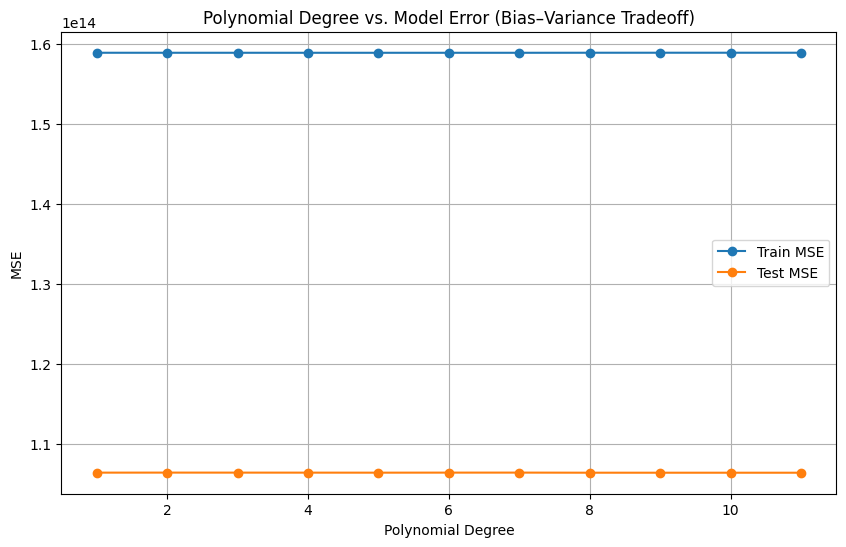

In [80]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# Choose a single meaningful feature
# ---------------------------
X = vehicles[['age']]     # you can change to 'odometer' or any numeric feature
y = vehicles['price']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

degrees = range(1, 12)
train_mse = []
test_mse = []

for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    train_pred = model.predict(X_train_poly)
    test_pred = model.predict(X_test_poly)

    train_mse.append(mean_squared_error(y_train, train_pred))
    test_mse.append(mean_squared_error(y_test, test_pred))

# ---------------------------
# Plot
# ---------------------------
plt.figure(figsize=(10,6))
plt.plot(degrees, train_mse, marker='o', label='Train MSE')
plt.plot(degrees, test_mse, marker='o', label='Test MSE')

plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.title("Polynomial Degree vs. Model Error (Bias–Variance Tradeoff)")
plt.legend()
plt.grid(True)
plt.show()

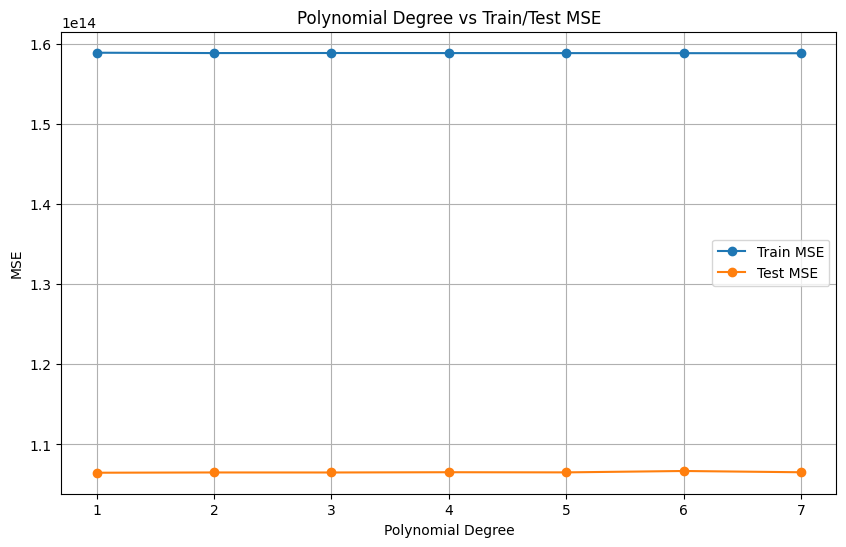

Train MSE: [158872603428575.0, 158830296908019.62, 158837343175767.9, 158828578114290.75, 158824703295256.06, 158817013264477.84, 158805921458200.25]
Test MSE: [106468312656948.7, 106501086252030.67, 106497923009745.78, 106530621414307.78, 106511479788442.83, 106684393144524.3, 106525549855586.36]


In [85]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------
# RE-DECLARE numeric feature list here
# ----------------------------------------
numeric_cols = [
    'age',
    'odometer',
    'miles_per_year',
    'cylinders_num',
    'fuel_score'
]

# ----------------------------------------
# REBUILD X AND y FROM THE CLEAN VEHICLES DF
# ----------------------------------------
X = vehicles[numeric_cols]
y = vehicles['price']

# ----------------------------------------
# TRAIN/TEST SPLIT
# ----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ----------------------------------------
# POLYNOMIAL DEGREE MSE CURVE
# ----------------------------------------
degrees = range(1, 8)
train_mse = []
test_mse = []

for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=False)
    
    # IMPORTANT: transform the SAME exact columns every loop
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    train_pred = model.predict(X_train_poly)
    test_pred = model.predict(X_test_poly)

    train_mse.append(mean_squared_error(y_train, train_pred))
    test_mse.append(mean_squared_error(y_test, test_pred))

# ----------------------------------------
# PLOT RESULTS
# ----------------------------------------
plt.figure(figsize=(10,6))
plt.plot(degrees, train_mse, marker='o', label='Train MSE')
plt.plot(degrees, test_mse, marker='o', label='Test MSE')
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.title("Polynomial Degree vs Train/Test MSE")
plt.legend()
plt.grid(True)
plt.show()

print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.